In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [2]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [3]:
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE + (3,))
])

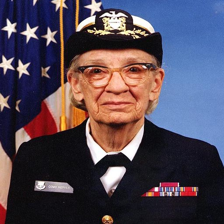

In [4]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
with tf.device('cpu:0'):
    result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

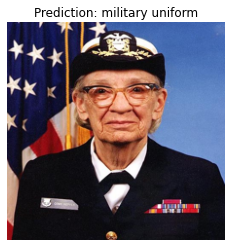

In [9]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

In [10]:
data_root = tf.keras.utils.get_file(
    'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

In [11]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [12]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [13]:
with tf.device('cpu:0'):
    result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [14]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['cardoon', 'rapeseed', 'daisy', 'artichoke', 'ant', 'daisy',
       'bell pepper', 'wool', 'umbrella', 'teddy', 'daisy', 'daisy',
       'daisy', 'daisy', 'candle', 'spider web', 'daisy', 'sea urchin',
       'pot', 'daisy', 'daisy', 'bee', 'daisy', 'chain', 'cardoon', 'pot',
       'daisy', 'flagpole', 'greenhouse', 'Bedlington terrier', 'daisy',
       "yellow lady's slipper"], dtype='<U30')

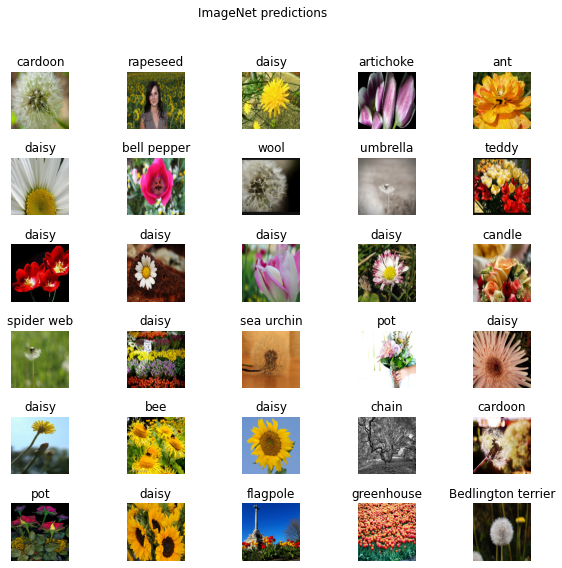

In [15]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace = 0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle('ImageNet predictions')

In [16]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [17]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3)
)

In [18]:
with tf.device('cpu:0'):
    feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [19]:
feature_extractor_layer.trainable = False

In [20]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
with tf.device('cpu:0'):
    predictions = model(image_batch)

In [22]:
predictions.shape

TensorShape([32, 5])

In [23]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics=['acc']
)

In [24]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [25]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs = 2,
                              steps_per_epoch = steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
115/115 [==============================] - 9s 80ms/step - loss: 0.3317 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 8s 66ms/step - loss: 0.3745 - acc: 0.8750: 1s - l


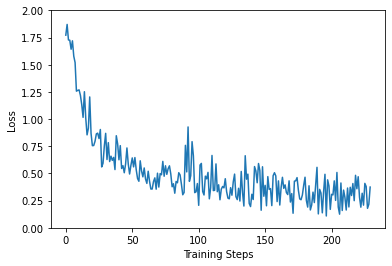

In [27]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

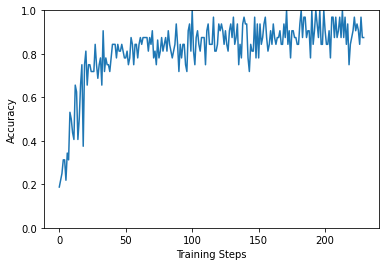

In [28]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [30]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [31]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [32]:
label_id = np.argmax(label_batch, axis=-1)

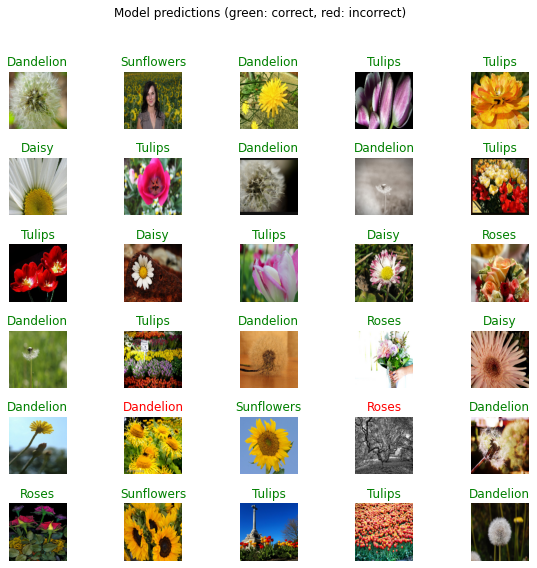

In [34]:
plt.figure(figsize = (10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

In [35]:
import time

t = time.time()

export_path = 'tmp/saved_models/{}'.format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: tmp/saved_models/1609265153\assets


INFO:tensorflow:Assets written to: tmp/saved_models/1609265153\assets


'tmp/saved_models/1609265153'

In [36]:
reloaded = tf.keras.models.load_model(export_path)

In [37]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
ab